In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
import joblib
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [2]:
live_data = pd.read_csv("./live_data.csv")
live_data_copy = live_data.__deepcopy__()

In [3]:
def preprocess_live_data(df):
    # Dropping columns that are not necessary for the model.
    columns_drop = ["id", "name", "host_name", "host_id", "last_review", "neighbourhood_group", "latitude", "longitude", "calculated_host_listings_count"]
    for column_drop in columns_drop:
        if column_drop in df.columns:
            df.drop(columns = [column_drop], inplace = True)
    return df

In [4]:
live_data_copy = preprocess_live_data(live_data_copy)

In [5]:
def feature_engineering(df):
    # One-hot encoding the room_type column.
    if "room_type" in df.columns:
        df = pd.get_dummies(df, columns=['room_type'], drop_first = False)
        df.rename(columns = {
            "room_type_Entire home/apt": "room_type_entire_home_apt",
            "room_type_Hotel room": "room_type_hotel_room",
            "room_type_Private room": "room_type_private_room",
            "room_type_Shared room": "room_type_shared_room"
            }, inplace = True)
    
    # Label Encoding the neighbourhood column.
    if "neighbourhood" in df.columns:
        label_encoder = LabelEncoder()
        df["neighbourhood"] = label_encoder.fit_transform(df["neighbourhood"])

    # Log Transforming the minimum_nights, number_of_reviews, and reviews_per_months columns.
    log_transform_columns = ["minimum_nights", "number_of_reviews", "reviews_per_month"]
    for log_transform_column in log_transform_columns:
        if log_transform_column in df.columns:
            df["log_" + log_transform_column] = np.log1p(df[log_transform_column])

    # Adding polynomial features
    selected_features = ['availability_365', 'number_of_reviews']
    poly = PolynomialFeatures(degree = 2, include_bias = False)
    poly_features = poly.fit_transform(df[["availability_365", "number_of_reviews"]])

    poly_feature_names = poly.get_feature_names_out(selected_features)
    X_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    df = pd.concat([df, X_poly_df], axis=1)
    df.drop(columns=selected_features, inplace=True)
    df.drop(columns = ["minimum_nights", "number_of_reviews", "reviews_per_month"],axis = 1, errors = "ignore", inplace = True)
    return df

In [6]:
live_data_copy = feature_engineering(live_data_copy)

In [7]:
live_data_copy.columns

Index(['neighbourhood', 'price', 'room_type_entire_home_apt',
       'room_type_hotel_room', 'room_type_private_room', 'log_minimum_nights',
       'log_number_of_reviews', 'log_reviews_per_month', 'availability_365^2',
       'availability_365 number_of_reviews', 'number_of_reviews^2'],
      dtype='object')

In [8]:
X_live_data = live_data_copy.drop(columns=['price'])
y_live_data = live_data_copy['price']

We have room_type_shared_room column missing from the original data. So, we add that and initialize all the values to False.

In [9]:
X_live_data["room_type_shared_room"] = False

In [10]:
X_live_data.columns

Index(['neighbourhood', 'room_type_entire_home_apt', 'room_type_hotel_room',
       'room_type_private_room', 'log_minimum_nights', 'log_number_of_reviews',
       'log_reviews_per_month', 'availability_365^2',
       'availability_365 number_of_reviews', 'number_of_reviews^2',
       'room_type_shared_room'],
      dtype='object')

We have to match the order of the columns from the original dataset to have the model work.

In [13]:
room_type_shared_column = X_live_data.pop("room_type_shared_room")
X_live_data.insert(4, "room_type_shared_room", room_type_shared_column)

In [14]:
X_live_data.columns

Index(['neighbourhood', 'room_type_entire_home_apt', 'room_type_hotel_room',
       'room_type_private_room', 'room_type_shared_room', 'log_minimum_nights',
       'log_number_of_reviews', 'log_reviews_per_month', 'availability_365^2',
       'availability_365 number_of_reviews', 'number_of_reviews^2'],
      dtype='object')

In [15]:
model = joblib.load("./randomforest_model.joblib")

In [16]:
live_data_predictions = model.predict(X_live_data)

In [17]:
X_live_data["predicted_price"] = live_data_predictions

In [18]:
live_data_copy["predicted_price"] = live_data_predictions

In [19]:
X_live_data.to_csv("predicted_data_X_live.csv", index = False)
live_data_copy.to_csv("predicted_data_live_data.csv", index = False)

In [20]:
predicted_data_X_live = pd.read_csv("predicted_data_X_live.csv")
predicted_data_X_live

,neighbourhood,room_type_entire_home_apt,room_type_hotel_room,room_type_private_room,room_type_shared_room,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,availability_365^2,availability_365 number_of_reviews,number_of_reviews^2,predicted_price
0,15,True,False,False,False,0.693147,0.693147,0.131028,133225.0,365.0,1.0,163.390671
1,7,False,False,True,False,0.693147,0.000000,NaN,1.0,0.0,0.0,48.100062
2,22,False,False,True,False,0.693147,0.693147,0.693147,127449.0,357.0,1.0,52.671676
3,16,True,False,False,False,1.386294,2.484907,0.737164,116964.0,3762.0,121.0,140.164575
4,6,False,False,True,False,1.098612,4.820282,0.883768,132496.0,44772.0,15129.0,53.876333
...,...,...,...,...,...,...,...,...,...,...,...,...
95,14,True,False,False,False,3.433987,0.000000,NaN,132496.0,0.0,0.0,131.425829
96,18,False,False,True,False,2.397895,3.044522,1.075002,24964.0,3160.0,400.0,35.091828
97,28,True,False,False,False,1.098612,4.189655,1.187843,7569.0,5655.0,4225.0,94.566433
98,16,True,False,False,False,3.433987,0.000000,NaN,0.0,0.0,0.0,77.126131


In [21]:
predicted_data_live_data = pd.read_csv("predicted_data_live_data.csv")
predicted_data_live_data

,neighbourhood,price,room_type_entire_home_apt,room_type_hotel_room,room_type_private_room,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,availability_365^2,availability_365 number_of_reviews,number_of_reviews^2,predicted_price
0,15,200,True,False,False,0.693147,0.693147,0.131028,133225.0,365.0,1.0,163.390671
1,7,44,False,False,True,0.693147,0.000000,NaN,1.0,0.0,0.0,48.100062
2,22,45,False,False,True,0.693147,0.693147,0.693147,127449.0,357.0,1.0,52.671676
3,16,255,True,False,False,1.386294,2.484907,0.737164,116964.0,3762.0,121.0,140.164575
4,6,55,False,False,True,1.098612,4.820282,0.883768,132496.0,44772.0,15129.0,53.876333
...,...,...,...,...,...,...,...,...,...,...,...,...
95,14,155,True,False,False,3.433987,0.000000,NaN,132496.0,0.0,0.0,131.425829
96,18,25,False,False,True,2.397895,3.044522,1.075002,24964.0,3160.0,400.0,35.091828
97,28,159,True,False,False,1.098612,4.189655,1.187843,7569.0,5655.0,4225.0,94.566433
98,16,144,True,False,False,3.433987,0.000000,NaN,0.0,0.0,0.0,77.126131


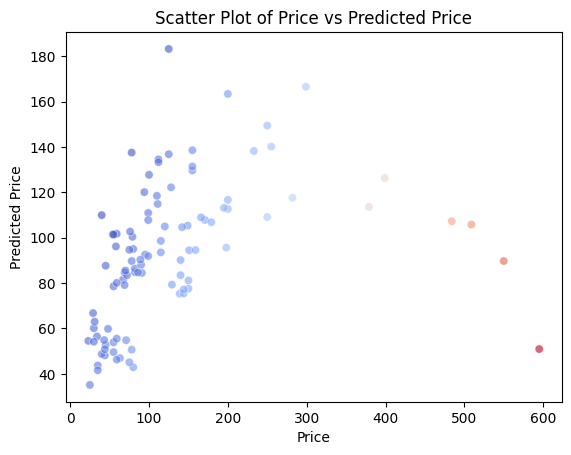

In [42]:
predicted_data_live_data['error'] = predicted_data_live_data['price'] - predicted_data_live_data['predicted_price']

plt.scatter(predicted_data_live_data['price'], predicted_data_live_data['predicted_price'], c = predicted_data_live_data["error"], cmap = "coolwarm", alpha=0.6, edgecolors="w", linewidth=0.5)
plt.title('Scatter Plot of Price vs Predicted Price')
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.show()


In [23]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'1234' # this is the password established during installation
port = r'5433' # default port estabalished during install
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

In [24]:
table_name = r'prediction_data'
schema = r"analytic"

In [25]:
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name


In [26]:
predicted_data_live_data.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')
print(f"Data saved to {table_name} of schema: {schema}")

Data saved to prediction_data of schema: analytic


To compare the predicted price and the original price, let's generate a percentage error column.

In [28]:
predicted_data_live_data['percentage_error'] = (abs(predicted_data_live_data['price'] - predicted_data_live_data['predicted_price']) / predicted_data_live_data['price']) * 100


In [29]:
predicted_data_live_data

,neighbourhood,price,room_type_entire_home_apt,room_type_hotel_room,room_type_private_room,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,availability_365^2,availability_365 number_of_reviews,number_of_reviews^2,predicted_price,percentage_error
0,15,200,True,False,False,0.693147,0.693147,0.131028,133225.0,365.0,1.0,163.390671,18.304664
1,7,44,False,False,True,0.693147,0.000000,NaN,1.0,0.0,0.0,48.100062,9.318324
2,22,45,False,False,True,0.693147,0.693147,0.693147,127449.0,357.0,1.0,52.671676,17.048169
3,16,255,True,False,False,1.386294,2.484907,0.737164,116964.0,3762.0,121.0,140.164575,45.033500
4,6,55,False,False,True,1.098612,4.820282,0.883768,132496.0,44772.0,15129.0,53.876333,2.043030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,14,155,True,False,False,3.433987,0.000000,NaN,132496.0,0.0,0.0,131.425829,15.209142
96,18,25,False,False,True,2.397895,3.044522,1.075002,24964.0,3160.0,400.0,35.091828,40.367313
97,28,159,True,False,False,1.098612,4.189655,1.187843,7569.0,5655.0,4225.0,94.566433,40.524256
98,16,144,True,False,False,3.433987,0.000000,NaN,0.0,0.0,0.0,77.126131,46.440186


For the final comparison, we will see if the tolerance of the predicted data falls under at least $50.

In [30]:
tolerance = 50
predicted_data_live_data["within_tolerance"] = abs(predicted_data_live_data["price"] - predicted_data_live_data["predicted_price"]) <= tolerance

In [35]:
predicted_data_live_data["within_tolerance"].value_counts()

within_tolerance
True     70
False    30
Name: count, dtype: int64

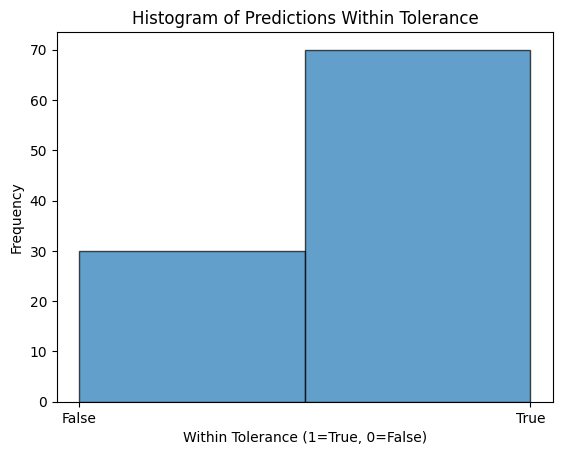

In [37]:
plt.hist(predicted_data_live_data['within_tolerance'].astype(int), bins=2, edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions Within Tolerance')
plt.xlabel('Within Tolerance (1=True, 0=False)')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

We see that 70 data points fall under the tolerance of $50.

So, with all the evaluations and performance of our model on the Chicago Airbnb dataset, we see that the model's performance is not ideal as the RMSE is above $50. After analyzing the model, we see that the price of a new listing could be off by about $54, either positive or negative, which is not generally admired in a short-term rental business.

Our analytical question was:  
> "Can we accurately predict Airbnb prices in Chicago using listing features?"

**Answer:** Yes, with a well-prepared dataset and a suitable model, we can predict prices with reasonable accuracy.

## Reflection

This project gave me a full experience of what it’s like to build and deploy a machine learning model—from data cleaning to making predictions on live data. I started with the Airbnb dataset and applied transformations like log scaling, feature engineering (creating polynomial features such as `number_of_reviews^2` and `availability_365 number_of_reviews`), and one-hot encoding for categorical values like `room_type`. Initially, everything went smoothly while working with the training data. I trained a Random Forest Regressor model and got promising results. But the real challenge began when I tried to make predictions on the live data.

I encountered multiple frustrating errors. First, there were **feature mismatches**: the live data had extra columns like `id`, `host_name`, and `host_id`, which were not in the training set, and it lacked some of the engineered columns like `room_type_private_room`, or `number_of_reviews^2`. The model threw a `ValueError` saying that the feature names did not match those it had seen during training. When I tried to fix that, I encountered another error: **"could not convert string to float: 'Lower West Side'"**. This made me realize that some columns, like `neighbourhood`, were still in string format, and the model couldn’t process them.

At this point, I had to backtrack and rethink how I prepared the live dataset. I dropped the unnecessary columns, recreated the log and squared features, and used `pd.get_dummies()` to match the one-hot encoded structure from the training phase. I also had to be careful to add any missing dummy columns with default values (like 0), to make sure the order and number of columns matched exactly. These steps taught me the **importance of keeping preprocessing steps consistent** between training and prediction. I now understand why data pipelines are essential in real-world deployments.

In the end, I was able to generate predictions for the live data and visualize the results. Although it took a lot of debugging and testing, the learning was worth it. I enjoyed the “aha” moment when the model finally worked without errors and gave logical predictions. This experience showed me that deploying a model is not just about building it—**it’s about making sure the entire system (data, transformations, and code) works smoothly together**. I now feel more confident handling live data and appreciate how small inconsistencies can lead to big problems if not handled properly. I also learned the value of documentation and reproducibility, which I’ll definitely carry into future projects.
